In [1]:
import os
import cv2
import tensorflow as tf
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
training_file = "dataset/train.p"
validation_file= "dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


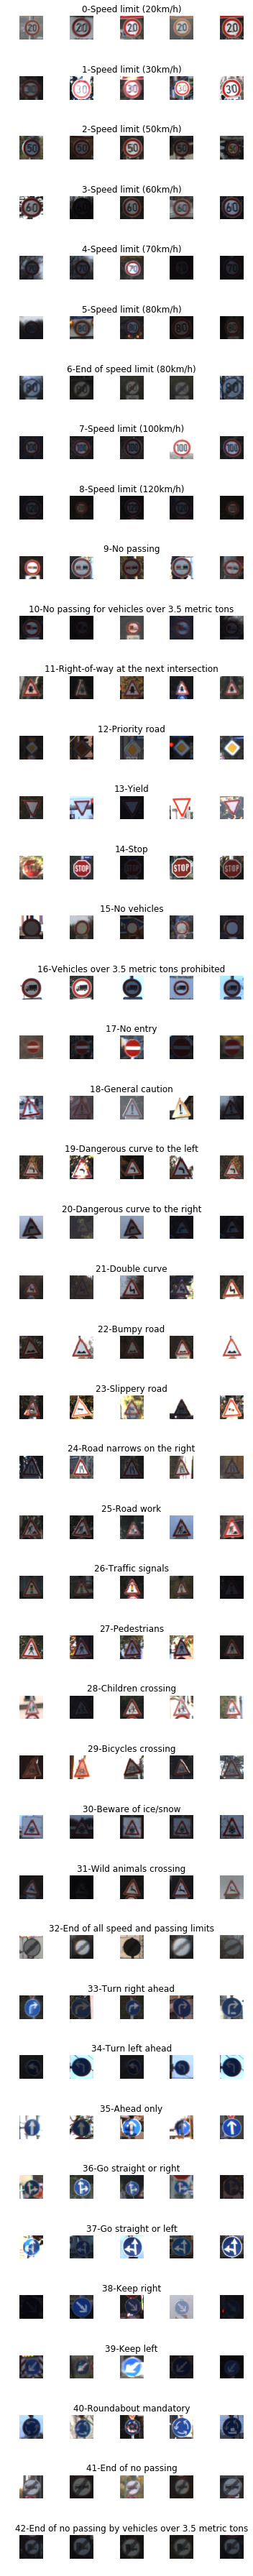

In [4]:
data = pd.read_csv("dataset/signnames.csv")
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))
            
    #(index, Series)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


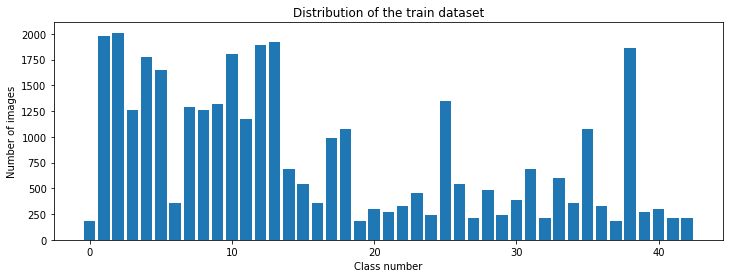

In [5]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


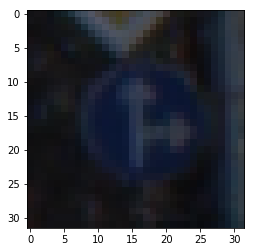

In [6]:
plt.imshow(X_train[1000])
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


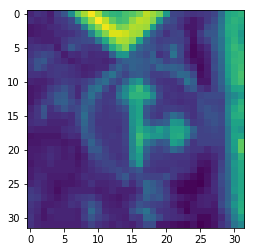

In [7]:
def gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    return gray

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

img = gray(X_train[1000])
plt.imshow(img)
print(img.shape)

(32, 32)


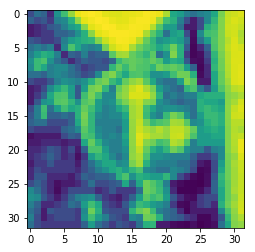

In [8]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
print(img.shape)

In [9]:
def preprocessing(img):
    img = gray(img)
    img = equalize(img)
    img = img / 255
    return img

In [10]:
X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

In [11]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [12]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [13]:
EPOCHS = 50
BATCH_SIZE = 20

In [14]:
def conv2d(x, kernel, Input, Output, mu = 0, sigma = 0.1):
    shape = (kernel, kernel, Input, Output)
    conv_W = tf.Variable(tf.truncated_normal(shape=shape, mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(Output))
    conv = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b
    conv = tf.nn.bias_add(conv, conv_b)
    return conv

In [15]:
def maxPool(conv, pool_size):
    pool = tf.nn.max_pool(conv, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='VALID')
    return pool

In [16]:
def fully(fc_i, Input, Output, mu = 0, sigma = 0.1):
    shape = (Input, Output)
    fc_W = tf.Variable(tf.truncated_normal(shape=shape, mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(Output))
    fc   = tf.matmul(fc_i, fc_W) + fc_b
    return fc

In [17]:
from tensorflow.contrib.layers import flatten

def trafficNet(x):
    
    conv1 = conv2d(x, 3, 1, 12)
    conv1 = tf.nn.relu(conv1)
    
    conv1 = conv2d(conv1, 3, 12, 24)
    conv1 = tf.nn.relu(conv1)
    pool1 = maxPool(conv1, 2)
    
    conv2 = conv2d(pool1, 5, 24, 36)
    conv2 = tf.nn.relu(conv2)
    
    conv2 = conv2d(conv2, 5, 36, 48)
    conv2 = tf.nn.relu(conv2)
    pool2 = maxPool(conv2, 2)
    
    
    fc0   = flatten(conv2)
    
    fc0 = tf.nn.dropout(fc0, 1)
    
    fc1 = fully(fc0, 1728, 512)
    fc1 = tf.nn.relu(fc1)

    fc2 = fully(fc1, 512, 256)
    fc2 = tf.nn.relu(fc2)

    logits = fully(fc2, 256, num_classes)
    
    return logits, conv1, conv2

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, num_classes)

In [19]:
logits, conv1, conv2 = trafficNet(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
rate = 0.001
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
stopped_at = 5
best_epoch = 0
best_val_acc = 0
history = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print()
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        history.append([train_accuracy, validation_accuracy])
   
        if validation_accuracy > best_val_acc:
            best_epoch, best_val_acc = i, validation_accuracy
            saver.save(sess, './model/model')
            print("Model saved")
        else:
            if i - best_epoch == stopped_at:
                print()
                print('Stopping after {} epochs without improvement'.format(stopped_at))
                break

Training...

EPOCH 1 ...
Training Accuracy = 0.970
Validation Accuracy = 0.933

Model saved
EPOCH 2 ...
Training Accuracy = 0.983
Validation Accuracy = 0.947

Model saved
EPOCH 3 ...
Training Accuracy = 0.990
Validation Accuracy = 0.962

Model saved
EPOCH 4 ...
Training Accuracy = 0.992
Validation Accuracy = 0.959

EPOCH 5 ...
Training Accuracy = 0.979
Validation Accuracy = 0.937

EPOCH 6 ...
Training Accuracy = 0.982
Validation Accuracy = 0.922

EPOCH 7 ...
Training Accuracy = 0.990
Validation Accuracy = 0.958

EPOCH 8 ...
Training Accuracy = 0.994
Validation Accuracy = 0.959

Stopping after 5 epochs without improvement


In [89]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f} %".format(test_accuracy * 100))

INFO:tensorflow:Restoring parameters from ./model/model
Test Accuracy = 92.819 %


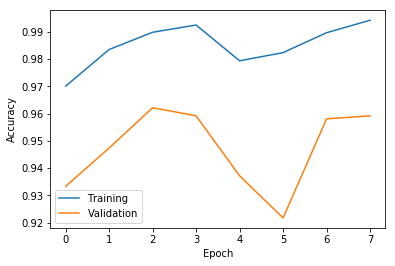

In [90]:
def plot_history(history):
    plt.plot(history)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

plot_history(history)

In [107]:
def localPic():
    paths = os.getcwd()+'/examples'
    image = mpimg.imread('./examples/pic2.jpg')
    return image

In [108]:
import requests
from PIL import Image

def netPic():
    url = "http://media.gettyimages.com/photos/traffic-sign-bicycling-prohibited-germany-picture-id486920319?s=170667a&w=1007"
#     url = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
#     url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"

    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    return img

In [109]:
def testing():
    return localPic() # LOCAL PIC
#     return netPic() # INTERNET PIC

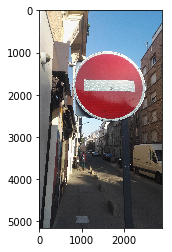

In [110]:
plt.imshow(testing())

In [111]:
#Preprocess image
def preprocess():
    img = testing()
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
#     print("image shape",img.shape)
    return img

In [112]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
def topFiveSoftmax(output, maxes):
    with tf.Session() as sess:
        tops = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(output)),k=5))
        for i in tops.indices[0].tolist():
            num = tops.indices[0].tolist().index(i)+1
            for j, cnt in zip(maxes,range(len(maxes))):
                classid = np.where(output[cnt]>=maxes[cnt])[0][0]
                for k, row in data.iterrows():
                    if i == row["ClassId"]:
                        print('Position {} :'.format(num), row["ClassId"] ,row["SignName"])

INFO:tensorflow:Restoring parameters from ./model/model
Position 1 : 17 No entry
Position 2 : 0 Speed limit (20km/h)
Position 3 : 34 Turn left ahead
Position 4 : 14 Stop
Position 5 : 8 Speed limit (120km/h)

PREDICT :  17 No entry


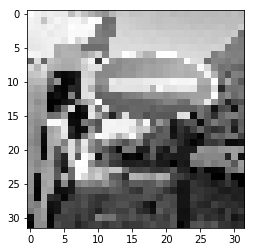

In [113]:
#prediction
def prediction():
    img = preprocess()
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    # plt.axis("off")
    new_saver = tf.train.import_meta_graph('./model/model.meta')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        new_saver.restore(sess, tf.train.latest_checkpoint('./model'))
        test_accuracy = evaluate(X_test, y_test)
        img = img.reshape(1, 32, 32, 1)
        output = sess.run(logits, feed_dict={x: img})
        
    maxes = np.amax(output,axis=1)
    cl = np.zeros((len(maxes)))
    cnt = 0
    topFiveSoftmax(output, maxes)
    for m,cnt in zip(maxes,range(len(maxes))):
        classid = np.where(output[cnt]>=maxes[cnt])[0][0]
        for i, row in data.iterrows():
            if classid == row["ClassId"]:
                print()
                print("PREDICT : ",row["ClassId"] ,row["SignName"])
                
                
prediction()

INFO:tensorflow:Restoring parameters from ./model/model
24
48


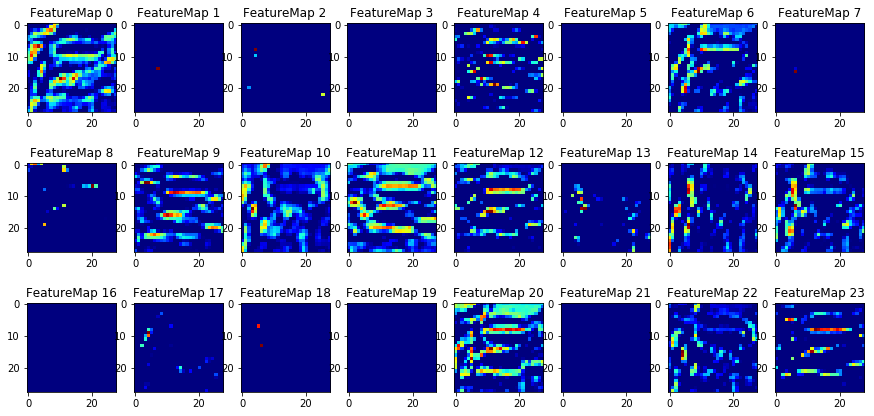

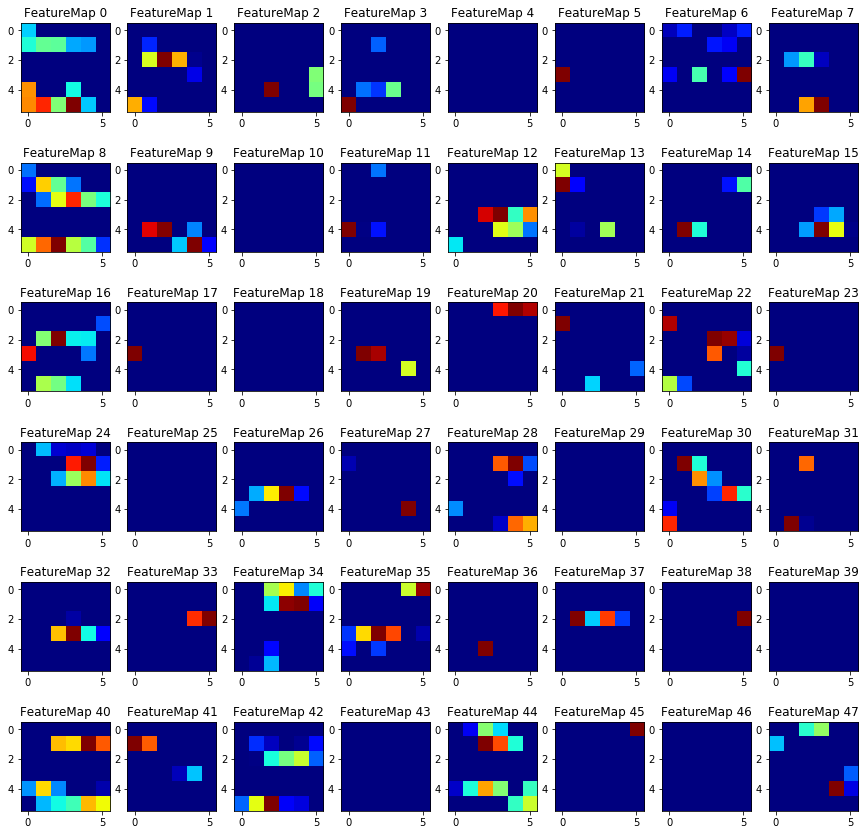

In [114]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    image_input = image_input.reshape(1, 32, 32, 1)
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    print(featuremaps)
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="jet")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="jet")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="jet")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="jet")
            
            
            
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    outputFeatureMap(preprocess(), conv1, plt_num=1)
    outputFeatureMap(preprocess(), conv2, plt_num=2)
